# Build a CV Train/Score/Evaluate Scaffold
* similar benefits as CI/CD pipeline
  * quickly try and validate new ideas
  * something to build on top of, e.g. feature selection
* start with ~1/2 of data
  * overfitting will occur--subsetting early mitigates some of this
* store all models and supporting data
* support various models
* bespoke strafified sampling for folds
* plotting routines for evaluation

## TODO
* save models to disk
* save tables
* metrics
* move variables --> dict --> model.json
* move boilerplate to boilerplate.ipynb

## Boilerplate

### Separate databases: __labels, models, features, cv__

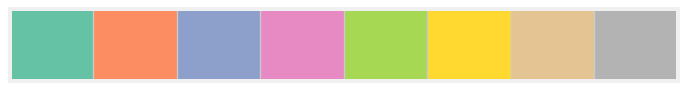

In [1]:
%run initialize.ipynb

import cPickle as pickle
import json

from pyspark.sql import Window

# spark.sql('CREATE DATABASE labels')
# spark.sql('CREATE DATABASE models')
# spark.sql('CREATE DATABASE features')
# spark.sql('CREATE DATABASE cv')

In [2]:
rcParams['figure.figsize'] = (12,8)
rcParams['figure.dpi'] = 96

# color_palette = 'Paired'
# colors = sns.color_palette(color_palette)
# sns.palplot(sns.color_palette(color_palette))
# rcParams['axes.prop_cycle'] = cycler(color=colors)

## Global Functions

In [3]:
def prop_dict_rolling(d):
    '''given a dictionary of probabilities, where
    the values are floats that sum to 1, 
    return a dictionary with the same keys, where
    the values are disjoint windows.
    usage note: top is inclusive. bottom is exclusive unless 0.
    usage note: if both elements are the same, skip'''
    rolling_sum = 0
    rolling = {}
    for k,v in d.iteritems():
        rolling[k] = (rolling_sum, rolling_sum+v)
        rolling_sum += v
    return rolling

def assign_group(df, d, strata_cols, colname):
    '''given (1) a dictionary of ranges,
    (2) a DF with random values ranked 
    by random block, and 
    (3) a name for the grouped columns,
    return DF with a new column that 
    assigns group membership'''
    
    window = Window.orderBy('dataset_rnd').partitionBy(*strata_cols)
    df = df.withColumn(
            'dataset_rk', F.percent_rank().over(window)
        )
    for i, (k,v) in enumerate(d.iteritems()):
        ## if the bottom is 0, make it -1 to include 0
        min_val = -1 if v[0] == 0 else min_val
        if i == 0:
            group_assign_cond = F.when(
                (col('dataset_rk') > min_val)
                & (col('dataset_rk') <= v[1]),
                F.lit(k)
            )
        else:
            group_assign_cond = group_assign_cond.when(
                (col('dataset_rk') > min_val)
                & (col('dataset_rk') <= v[1]),
                F.lit(k)
            )
    
    return df.withColumn(colname, group_assign_cond)

def modify_group_for_dim(df, d, colname):
    '''given a DF with a groups assigned (variable colname),
    apply a dictionary to post-process the groups according 
    to that one dimension. returns original DF with modified
    colname column.
    e.g. move specific seasons to the holdout or throwaway sets.
    '''
    for grp, grp_dict_list in dimensional_dataset_proportions.iteritems():
        for grp_dict in grp_dict_list:
            window = Window.orderBy('dim_rnd')\
                           .partitionBy(grp_dict['dim'], colname)
            df = df.withColumn('dim_rk', F.percent_rank().over(window))

            ## if (1) the column is within the set values,
            ## (2) the pre-existing group falls within those set values, and
            ## (3) the random value is below the set threshold,
            ## then override and modify the group membership
            df = df.withColumn(
                colname, 
                F.when(
                    (col(grp_dict['dim']).isin(grp_dict['vals']))
                    & (col(colname).isin(grp_dict['from_groups'])) 
                    & (col('dim_rk') >= grp_dict['prop']), 
                  grp
                ).otherwise(col(colname))
            )
    return df

## Simple Spread Model

### Labels
* did_win

### Features
* season
* week_id
* is_home
* dave_or_wtddvoa
* offensedvoa
* defensedvoa
* s_t_dvoa

### Generate Test Data

In [4]:
ranks = spark.table('dvoa').select(
        'team_id','season','week_id','dave_or_wtddvoa',
        'offensedvoa','defensedvoa','s_t_dvoa'
    ).cache()
game_feats = spark.table('team_game_line_labels').select(
        'game_id','season','week_id','team_id','is_home'
    ).cache()

features = game_feats.join(
        ranks, on=['team_id','season','week_id']
    )
labels = spark.table('team_game_line_labels').select(
    ## index
    'game_id','team_id',
    ## strata
    'is_home','is_fav_sbr',
    ## labels
    'did_win','final_margin','did_cover_pfr',
    'did_cover_sbr','did_cover_sbr_open'
)

assert features.count() == labels.count()

In [5]:
features.write.mode('overwrite').saveAsTable('features.0109_test')
labels.write.mode('overwrite').saveAsTable('labels.0109_test')

### Train and Score Model

#### Define variables -- eventually for model.json

In [6]:
features_tbl = 'features.0109_test'
labels_tbl = 'labels.0109_test'

features_list = [
    'season',
    'week_id',
    'is_home',
    'dave_or_wtddvoa',
    'offensedvoa',
    'defensedvoa',
    's_t_dvoa'
]

label_col = 'did_win'
pos_labels = [1]
neg_labels = [-1]

index = ['game_id','team_id']

nfolds = 5
kfold_seed = 99

dataset_seed = 9
strata_cols = ['did_win','is_home']

## this says holdout 50%, and the other 50% goes in training
global_dataset_proportions = {
    'holdout': 0.5,
    'throw_away': 0,
    'in_training': 0.5,
    'scoring_only': 0
}

## this says to throw away all games where 
## team is Visitor
dimensional_dataset_proportions = {
    'throw_away': [{
        'dim': 'is_home',
        'from_groups': ['in_training','holdout','scoring_only'],
        'vals': [0],
        'prop': 0.0
    }]
    
}

model_seed = 9
model = 'xgboost.XGBClassifier'
model_params = {
    'booster':'gbtree',
    'gamma': 0,
    'learning_rate': 0.1,
    'max_depth': 3,
    'max_features': 'auto',
    'n_estimators': 200,
    'n_jobs': 1,
    'nthread': None,
    'objective': 'binary:logistic',
    'random_state': model_seed,
    'silent': True,
    'subsample': 0.9
}

In [7]:
assert sum(global_dataset_proportions.values()) == 1
assert type(global_dataset_proportions) is dict
for d in dimensional_dataset_proportions.values():
    assert type(d) is list
    assert sum([type(x) is not dict for x in d]) == 0
    
## other assertions
# tables exists
# columns are in tables
# 

#### Select data and assign random values for binning

In [8]:
features_prep = spark.table(features_tbl).select(
        *( set(features_list) | set(index) )
    )
labels_prep = spark.table(labels_tbl).select(
        *( set(index) | set(strata_cols) | set([label_col]) )
    )

labels_prep = labels_prep.withColumn(
        'dataset_rnd', F.rand(dataset_seed)
    ).withColumn(
        'dim_rnd', F.rand(dataset_seed)
    ).withColumn(
        'kfold_rnd', F.rand(kfold_seed)
    ).withColumn(
        'label', 
        F.when(col(label_col).isin(pos_labels), 1)
         .when(col(label_col).isin(neg_labels), 0)
         .otherwise(None)
    ).filter(
        col('label').isNotNull()
    )

#### Apply stratified sampling
* TODO: pre-bin the values (either by percentile/decile/quantile/etc, or by defined groups) if requested. purely a nice-to-have
* move to a function
* 4 uses for strata
 * holdout
 * throw away
 * in training folds or scoring only
 * k-fold
* techniques
 * for k-fold, it's easy as it's uniform across folds
 * holdout/throw away/in training/score only can be performed together
* options
 * global: cut the count by this proportion, for all blocks
 * dimensional: after the global cut, further cut a single dimensional value
   * e.g. could be used to remove certain years or weeks
   * for now, this will be manual after the dict is created
   * or have skip_values dict of column: [values] to 0 out

apply global proportions

In [9]:
global_rolling = prop_dict_rolling(global_dataset_proportions)
datasets = assign_group(labels_prep, global_rolling, strata_cols, 'dataset')

datasets.groupby('did_win','is_home').pivot('dataset').count().toPandas()

,did_win,is_home,holdout,in_training
0,1,NaN,19,19
1,1,0.0,616,617
2,-1,1.0,616,617
3,1,1.0,830,830
4,-1,NaN,19,19
5,-1,0.0,830,830


apply dimensional proportions

In [10]:
datasets = modify_group_for_dim(
    datasets, dimensional_dataset_proportions, 'dataset' 
)

datasets.groupby('did_win','is_home').pivot('dataset').count().toPandas().fillna(0)

,did_win,is_home,holdout,in_training,throw_away
0,1,0.0,19.0,19.0,0.0
1,1,0.0,0.0,0.0,1233.0
2,-1,1.0,616.0,617.0,0.0
3,1,1.0,830.0,830.0,0.0
4,-1,0.0,19.0,19.0,0.0
5,-1,0.0,0.0,0.0,1660.0


#### Stratified Sampling -- CV Set -- TODO: what if no folds desired, e.g. 70/30 split, 1 model

In [11]:
scoring_rows = datasets.filter(col('dataset') == 'scoring_only')
training_rows = datasets.filter(col('dataset') == 'in_training')

In [12]:
## assign K folds
if nfolds > 1:
    folds_dict = {k: 1./nfolds for k in np.arange(nfolds)}
    folds_rolling = prop_dict_rolling(folds_dict)
    training_rows = assign_group(training_rows, folds_rolling, strata_cols, 'fold')

    training_rows.groupby('did_win','is_home').pivot('fold').count().toPandas()
else:
    training_rows = training_rows.withColumn('fold', F.lit(0))

,did_win,is_home,0,1,2,3,4
0,1,NaN,4,4,3,4,4
1,-1,1.0,124,123,123,123,124
2,1,1.0,166,166,166,166,166
3,-1,NaN,4,4,3,4,4


In [13]:
training = features_prep.join(
    training_rows.select(*(index + ['label','fold'])),
    on=index
)
scoring_only = features_prep.join(
    scoring_rows.select(*(index + ['label'])),
    on=index
)

assert training.count() == training_rows.count()
assert scoring_only.count() == scoring_rows.count()

In [14]:
training.limit(5).toPandas()
scoring_only.limit(5).toPandas()

,game_id,team_id,week_id,defensedvoa,dave_or_wtddvoa,season,offensedvoa,is_home,s_t_dvoa,label,fold
0,200811090mia,mia,10,-3.0,10.6,2008,14.9,1.0,-8.5,1,0
1,200811160mia,mia,11,-0.5,10.1,2008,15.3,1.0,-8.2,1,2
2,200811230mia,mia,12,0.5,6.6,2008,16.7,1.0,-9.4,0,1
3,200812140mia,mia,15,2.4,8.5,2008,14.6,1.0,-6.8,1,3
4,200901040mia,mia,18,3.0,7.5,2008,17.1,1.0,-4.9,0,1


,game_id,team_id,week_id,defensedvoa,dave_or_wtddvoa,season,offensedvoa,is_home,s_t_dvoa,label


#### Train K Folds and Score

In [15]:
import importlib

model_obj_path = '.'.join(model.split('.')[:-1])
model_name = model.split('.')[-1]
model_package = importlib.import_module(model_obj_path)
model_class = getattr(model_package, model_name)

## as opposed to spark:
train_in_memory = model.split('.')[0] in ['sklearn','xgboost']

In [16]:
if train_in_memory is True:
    training_df = training.toPandas().set_index(index)
    scoring_only_df = scoring_only.toPandas().set_index(index)
    
    ## folds
    training_scoring_sets  = {
        f: {
            'train': training_df[training_df['fold'] != f],
            'score': training_df[training_df['fold'] == f]
        }
        for f in np.arange(nfolds)
    }
    ## full sets
    training_scoring_sets['full'] = {
        'train': training_df,
        'score': scoring_only_df
    }

    cv_models = {
        set_nbr: model_class(
            **model_params
        ).fit(
            np.array(set_data['train'][features_list].values.tolist()),
            set_data['train']['label'].ravel()
        )
        # for fold 0, 1, ... and full set
        for set_nbr, set_data in training_scoring_sets.iteritems()
        # skip training the full set if there's no scoring data
        if set_data['score'].shape[0] > 0
    }
    
    ## TODO: pickle.dump, line 246 of train2.png
    for i, (set_nbr, mdl) in enumerate(cv_models.iteritems()):
        curr_scoring = training_scoring_sets[set_nbr]['score']
        curr_scoring['score'] = mdl.predict_proba(
                curr_scoring[features_list].values.tolist()
            )[:,1]
        
        if i == 0:
            scores_df = curr_scoring
        else:
            scores_df = scores_df.append(curr_scoring)

/Users/joshplotkin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Evaluate

In [17]:
eval_df = scores_df[['score','label']]

acc_curve = {}
for i in np.arange(0,1.01,0.01):
    eval_df['pred'] = (eval_df['score'] >= i).astype(int)
    eval_df['correct'] = eval_df['pred'] == eval_df['label']
    acc_curve[i] = eval_df['correct'].mean()

/Users/joshplotkin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/joshplotkin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


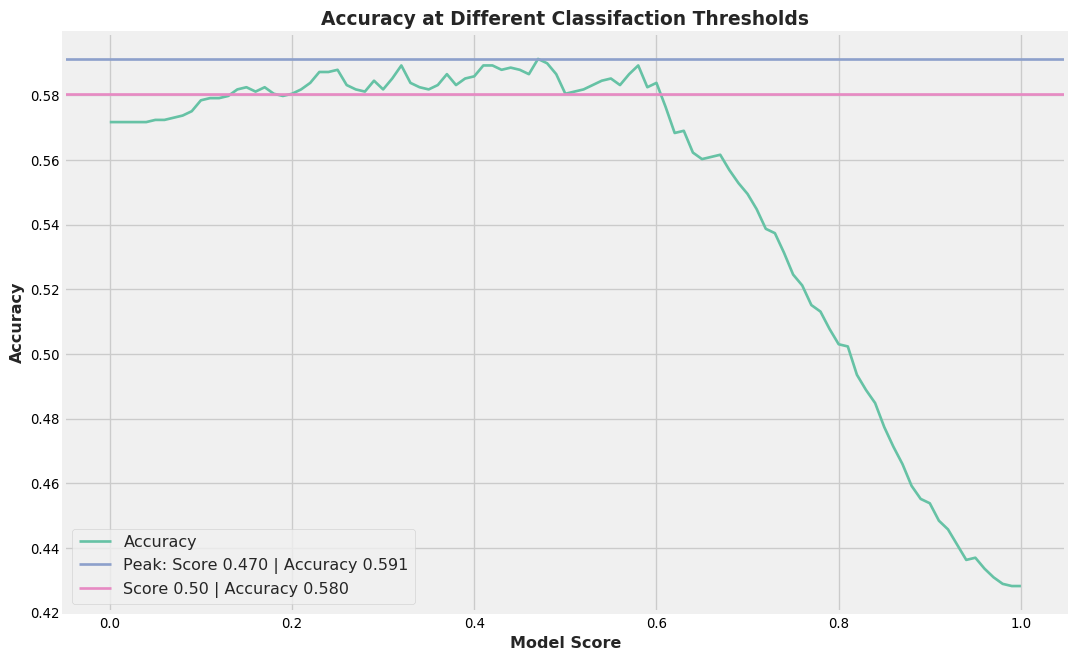

In [26]:
acc_df = pd.DataFrame\
           .from_dict(acc_curve, orient='index')\
           .sort_index()\
           .rename(columns={0:'Accuracy'})
acc_df.index.name = 'Model Score'

peak = acc_df.loc[acc_df.idxmax()]
peak_score = peak.index[0]
peak_acc = peak.iloc[0,0]
x0_50_acc = acc_df.loc[0.50, 'Accuracy']

_ = acc_df.plot(
    kind='line', title='Accuracy at Different Classifaction Thresholds'
)
_ = plt.axhline(
    y=peak_acc, xmin=0, xmax=1, 
    label='Peak: Score {:.3f} | Accuracy {:.3f}'.format(peak_score, peak_acc),
    linewidth=2, color=colors[2]
)
_ = plt.axhline(
    y=acc_df.loc[0.50, 'Accuracy'], xmin=0, xmax=1, 
    label='Score 0.50 | Accuracy {:.3f}'.format(x0_50_acc),
    linewidth=2, color=colors[3]
)
_ = plt.legend()
_ = plt.ylabel('Accuracy')

#### Plot Scores -- TODO turn this into a function and call using top *VARIABLES*

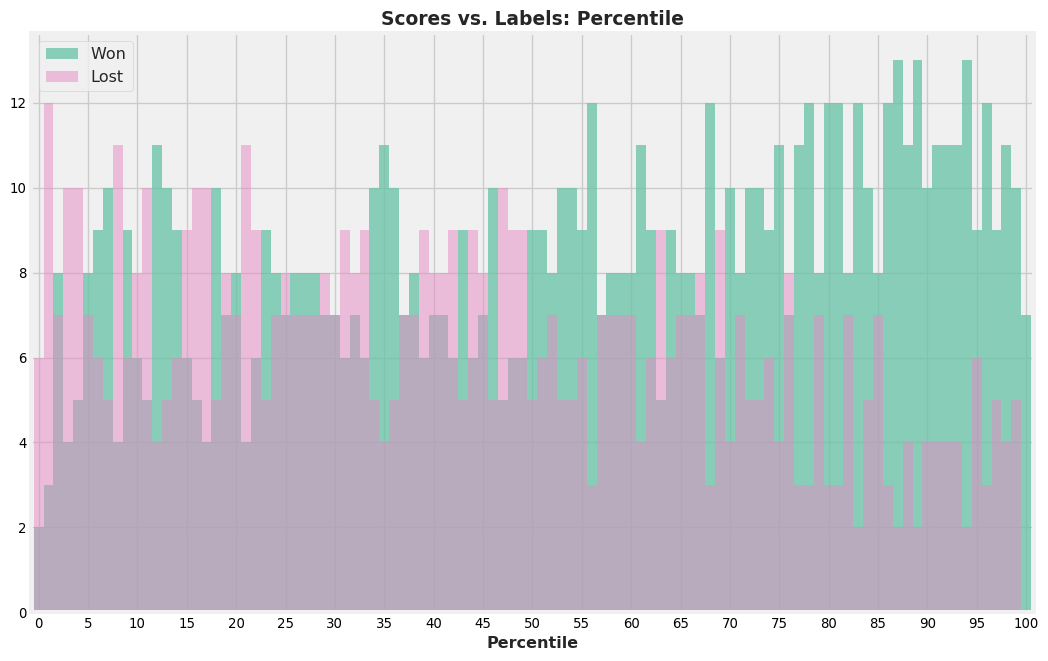

In [41]:
## VARIABLES
plot_bins = [100]
label_map = {
    '0': 'Lost',
    '1': 'Won'
}
x_values = 'Percentile' # 'Score Bins' # 
##

for nbins in plot_bins:  
    ## bin
    if x_values == 'Score Bins':
        scores_df[x_values] = scores_df['score'].apply(
            lambda x: int(np.round(x*nbins, 0))
        )
        scores_to_plot = spark.createDataFrame(scores_df[[x_values,'label']])
    elif x_values == 'Percentile':
        scores_pct = scores_df[['score','label']].sort_values(by='score')
        scores_pct['rk'] = np.arange(0, scores_pct.shape[0], 1)
        scores_pct['rk'] /= float(scores_pct.shape[0])
        scores_pct[x_values] = scores_pct['rk'].apply(
            lambda x: int(np.round(x*nbins, 0))
        )
        scores_to_plot = spark.createDataFrame(scores_pct[[x_values,'label']])

    new_idx = np.arange(0, nbins+1, 1)

    scores_to_plot = scores_to_plot.groupby(x_values)\
                                   .pivot('label')\
                                   .count()\
                                   .fillna(0)\
                                   .toPandas()\
                                   .rename(columns=label_map)\
                                   .set_index(x_values)\
                                   .reindex(new_idx)\
                                   .fillna(0)\
                                   .sort_index()

    ax = plt.figure().add_subplot(111)
    scores_colors = (colors[0], colors[3], colors[5], colors[7])
    for i, c in enumerate(scores_to_plot.columns.tolist()[::-1]):
        _ = scores_to_plot[c].plot(
                kind='bar', rot=0, color=scores_colors[i], width=1,
            alpha = 0.75 - 0.25*i,
            )
        if c == scores_to_plot.columns[0]:
            _ = plt.title('Scores vs. Labels: {}'.format(x_values))
            _ = plt.legend()
            a, b = plt.xticks()
            _ = plt.xticks(a[::5], b[::5])

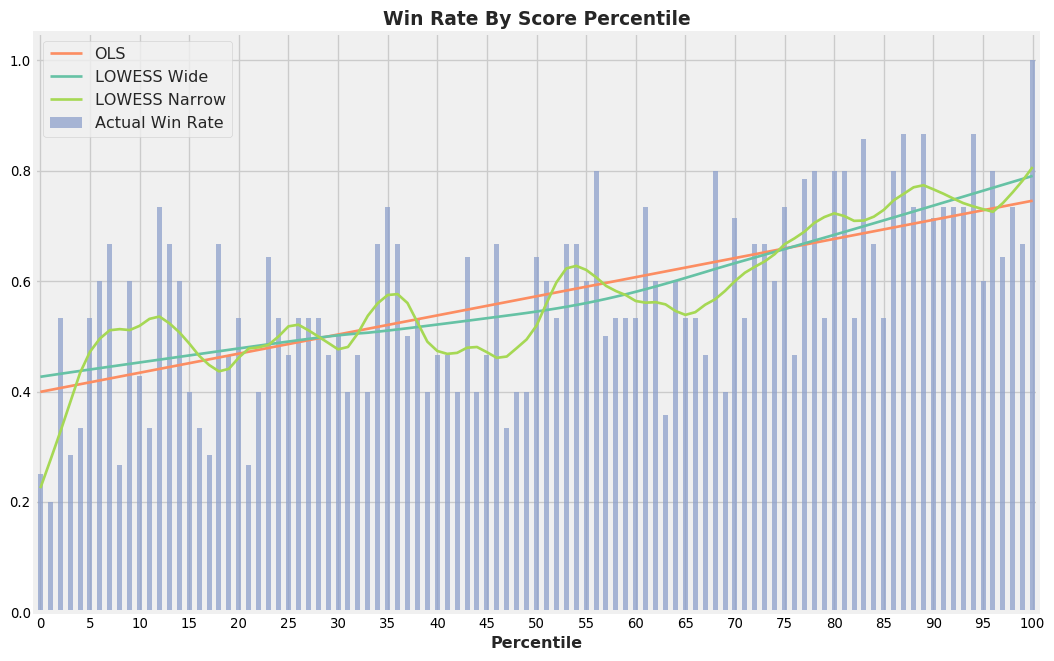

In [49]:
import statsmodels.api as sm

ax = plt.figure().add_subplot(111)

scores_to_plot['Win Rate'] = scores_to_plot['Won'].astype(float) \
                                / ( scores_to_plot['Won'] 
                                   + scores_to_plot['Lost'] )
_ = scores_to_plot['Win Rate'].plot(
    kind='bar', color=colors[2], rot=0, alpha = 0.75, ax=ax,
    title='Win Rate By Score Percentile', label='Actual Win Rate'
)

## can't have space in field for statsmodels
scores_trend = scores_to_plot\
                .reset_index(drop=False)\
                [['Percentile','Win Rate']]\
                .rename(columns={'Win Rate':'WR'})

## OLS Trend
model = sm.formula.ols(formula='WR ~ Percentile', data=scores_trend)
res = model.fit()
scores_trend = scores_trend.assign(Trend=res.fittedvalues)
_ = scores_trend['Trend'].plot(kind='line', ax=ax, color=colors[1], label='OLS')

## LOWESS Trend
lowess = sm.nonparametric.lowess

z = lowess(scores_trend['WR'], scores_trend['Percentile'])
scores_trend = scores_trend.assign(Trend=z[:,1])
_ = scores_trend['Trend'].plot(kind='line', ax=ax, color=colors[0], label='LOWESS Wide')

w = lowess(scores_trend['WR'], scores_trend['Percentile'], frac=1./10)
scores_trend = scores_trend.assign(Trend=w[:,1])
_ = scores_trend['Trend'].plot(kind='line', ax=ax, color=colors[4], label='LOWESS Narrow')

_ = plt.legend()

a, b = plt.xticks()
_ = plt.xticks(a[::5], b[::5])

#### Feature importance

#### Feature contribution

#### Evaluation, e.g. super contest style

## Simple Over/Under Model

In [ ]:
spark.table('over_under_labels').limit(5).toPandas()